In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque
from keras.regularizers import l2, l1, l1_l2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *



2022-06-01 14:50:58.366961: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-01 14:50:58.373650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 14:50:58.373670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()


shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [11]:
boosted_model =  tf.keras.models.load_model('pb_file')

boosted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


2022-06-01 15:17:31.595942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 15:17:31.595972: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 15:17:31.595994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-01 15:17:31.596401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def exist(path, modeltopred):

    if (os.path.exists(path)==False):
        print(path)
        print('saving')
        np.save(path, modeltopred.predict(x_test))
        print('saved')
    else : print(f'{path} already exists')

In [13]:
ref_path = 'conversion_optimization/tests/ref_predicts.npy'
exist(ref_path, boosted_model)

conversion_optimization/tests/ref_predicts.npy
saving
31250/31250 [==============================] - 38s 1ms/step
saved


In [ ]:
import ROOT
from ROOT import TCanvas, TColor, TGaxis, TH1D, TPad, TLegend, TLatex, TH2D, TF1, TLine, TProfile
from ROOT import kBlack, kBlue, kRed, kGreen, kMagenta


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


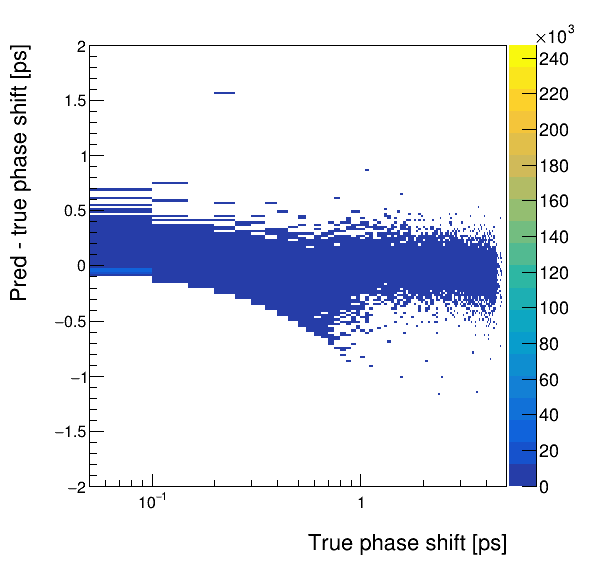

In [15]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

"""# Select events with >240MeV
ECUT = 0.24"""

inds = np.where((y_test[:,0] ))#> ECUT/16))[0]

# Model predictions in array
model_predictions = np.load(ref_path)

h1 = TH2D("histogram1", "histogram2", 100, 0, 5, 200, -2 ,2)
h1.Sumw2()
denorm=16
prof1 = h1.ProfileX("p1", 1, -1, "s")
prof1.Draw("HIST E3")


for x, y in zip(y_test[inds], model_predictions[inds]):
    h1.Fill(x*denorm, (y-x)*denorm)

h1.GetYaxis().SetTitleFont(43)
h1.GetXaxis().SetTitleFont(43)
h1.GetYaxis().SetTitleOffset(1.55)

h1.SetStats(0)


c = TCanvas("c", "c", 600, 600)
c.cd();
c.SetBottomMargin(0.15)
c.SetTopMargin(0.08)
c.SetLeftMargin(0.15)
c.SetRightMargin(0.15)
c.SetLogx()


h1.GetYaxis().SetTitle("Pred - true phase shift [ps]")#"##splitline{One entry per network}{[normalized to unity]}")#"Normalized to unity")
h1.GetXaxis().SetTitle("True phase shift [ps]")#f"{xtitle} of E^{{T}}_{{pred}} - E^{{T}}_{{true}} [GeV]")
#h1.GetYaxis().SetRangeUser(0,0.45)
#h1.GetXaxis().SetRangeUser(0, 0.5)

#SetLabelSize(0.05)
h1.GetXaxis().SetLabelSize(0.03)
h1.GetYaxis().SetLabelSize(0.03)

h1.GetYaxis().SetTitleOffset(1.8)
h1.GetXaxis().SetTitleOffset(1.5)


h1.GetXaxis().SetTitleSize(24)
h1.GetYaxis().SetTitleSize(24)



h1.Draw("colz")




l = TLatex() 
l.SetTextSize(18)
l.SetTextFont(42)

l.SetNDC()
l.SetTextColor(kBlack)
l.DrawLatex(0.5, 0.5, "some text: E^{{T}}_{{true}} > 1 GeV")


c.Draw()